In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, split, col, regexp_extract, count, sum, max, min, avg, date_format, to_date, dayofweek, unix_timestamp
from pyspark.sql.types import StringType, IntegerType

Setting variables

In [2]:
path_wd   = os.getcwd() 
path_root = path_wd.rsplit("\\",1)[0]

path_data = path_root + '\\data\\'

fname_in = path_data + 'access_log.txt'

Initialize SparkSession

In [3]:
spark = SparkSession.builder.appName("WebServerLogAnalysis").getOrCreate()

log_df = spark.read.text(fname_in)

# log_df.show(10)

Data Extraction

In [4]:
# Extracting fields from the log file using regular expressions
log_df = log_df.select(
    regexp_extract("value", r'^(\S+)', 1).alias("ClientIP"),
    regexp_extract("value", r'\[(.*?)\]', 1).alias("Datetime"),
    regexp_extract("value", r'\"(.*?)\"', 1).alias("Request"),
    regexp_extract("value", r' (\d{3}) ', 1).cast("int").alias("StatusCode"),
    regexp_extract("value", r' (\d+)$', 1).cast("int").alias("ResponseSize")
)

# log_df.show(10)

a. 10 maiores origens de acesso (Client IP) por quantidade de acesso

In [5]:
top_10_client_ips = log_df.groupBy("ClientIP") \
                          .agg(count("*").alias("AccessCount")) \
                          .orderBy(col("AccessCount").desc()) \
                          .limit(10)

top_10_client_ips_df = top_10_client_ips.toPandas()

display(top_10_client_ips_df)

,ClientIP,AccessCount
0,10.216.113.172,158614
1,10.220.112.1,51942
2,10.173.141.213,47503
3,10.240.144.183,43592
4,10.41.69.177,37554
5,10.169.128.121,22516
6,10.211.47.159,20866
7,10.96.173.111,19667
8,10.203.77.198,18878
9,10.31.77.18,18721


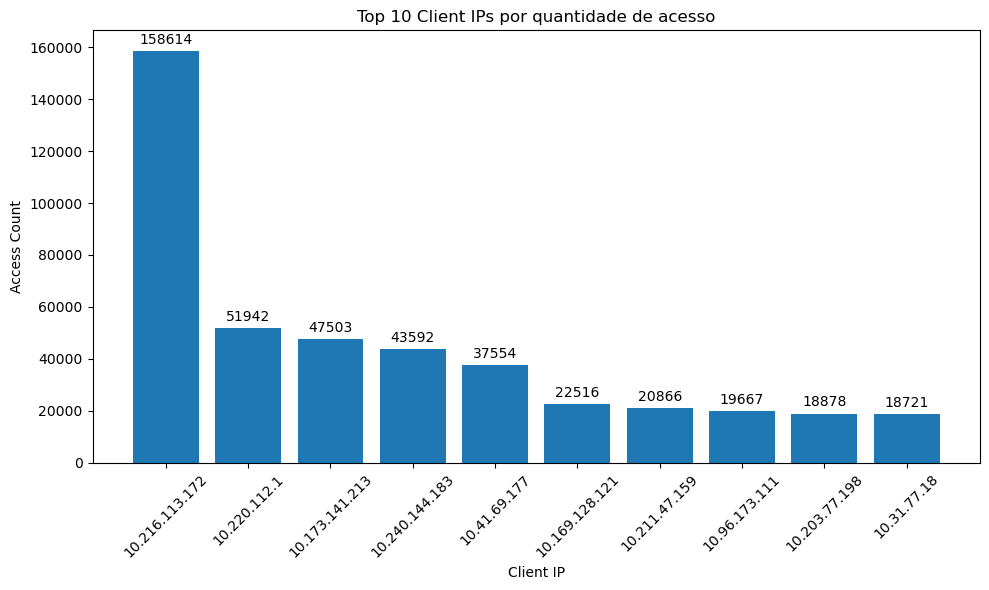

In [6]:
# data viz
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_client_ips_df["ClientIP"], top_10_client_ips_df["AccessCount"])

# Adding the values as labels on the graph bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate('{}'.format(top_10_client_ips_df["AccessCount"][i]),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel("Client IP")
plt.ylabel("Access Count")
plt.title("Top 10 Client IPs por quantidade de acesso")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

b. Os 6 endpoint mais acessados, desconsiderando endereços que representam arquivos

c. Quantidade de Client Ip distintos

In [7]:
distinct_client_ips = log_df.select("ClientIP").distinct().count()
print("Quantidade de Client IP distintos:", distinct_client_ips)

Quantidade de Client IP distintos: 333923


d. Total de dias de dados representados

In [8]:
log_df = log_df.withColumn("Timestamp", unix_timestamp("Datetime", "dd/MMM/yyyy:HH:mm:ss Z").cast(IntegerType()))

# Find the minimum and maximum timestamps to determine the range of dates
min_timestamp = log_df.selectExpr("min(Timestamp) as min_timestamp").collect()[0].min_timestamp
max_timestamp = log_df.selectExpr("max(Timestamp) as max_timestamp").collect()[0].max_timestamp

min_datetime = datetime.utcfromtimestamp(min_timestamp)
max_datetime = datetime.utcfromtimestamp(max_timestamp)

num_days = (max_datetime - min_datetime).days

print("Quantidade de Dias de Dados Representados:", num_days)

Quantidade de Dias de Dados Representados: 870


e. Quantidade de bytes do conteúdo da resposta, lista do maior, menor e média de volume total por Status Code

In [9]:
data_volume_by_status = log_df.groupBy("StatusCode") \
                              .agg(sum("ResponseSize").alias("TotalDataVolume"), 
                                   max("ResponseSize").alias("MaxDataVolume"), 
                                   min("ResponseSize").alias("MinDataVolume"), 
                                   avg("ResponseSize").alias("AvgDataVolume"))

data_volume_by_status.show()

+----------+---------------+-------------+-------------+------------------+
|StatusCode|TotalDataVolume|MaxDataVolume|MinDataVolume|     AvgDataVolume|
+----------+---------------+-------------+-------------+------------------+
|       416|         146094|          314|          230| 230.7962085308057|
|       206|    19446271433|      6082298|            1| 343634.4130235024|
|       301|        7977309|          289|          197| 215.2829307785724|
|       403|         105060|         2366|          202|            1400.8|
|       404|       16644817|          756|          174|204.06562783512737|
|       200|   785747256645|     80215074|            1|  199032.395632696|
|       304|           null|         null|         null|              null|
|       302|          56840|           20|           20|              20.0|
|       405|         150339|          298|          189|265.14814814814815|
|       500|           1725|          345|          345|             345.0|
|       401|

f. Dia da semana que apresenta o maior número de erros do tipo "HTTP Client Error"

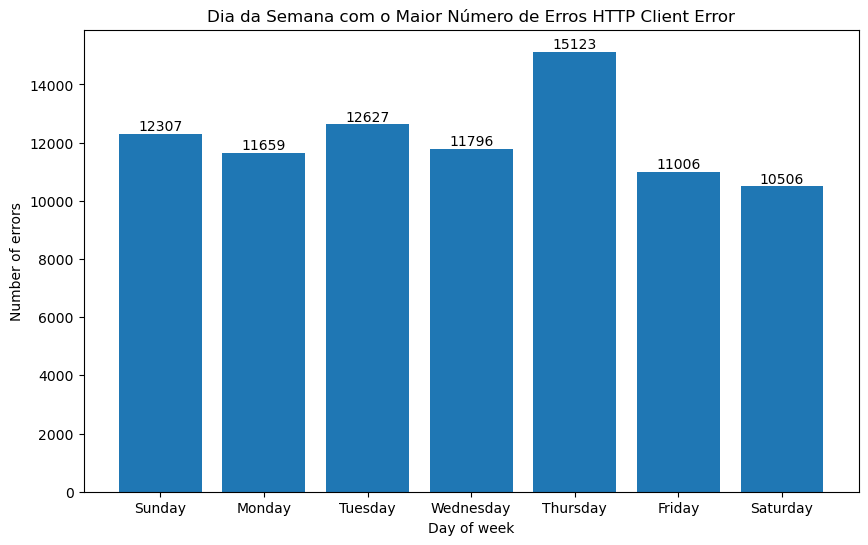

In [10]:
error_df = log_df.filter(log_df.StatusCode >= 400)
# Converting the "Datetime" column to a date and time format readable by pandas
error_df = error_df.withColumn("Datetime", unix_timestamp("Datetime", "dd/MMM/yyyy:HH:mm:ss Z").cast("timestamp"))

error_pd_df = error_df.toPandas()

error_pd_df["DayOfWeek"] = error_pd_df["Datetime"].dt.dayofweek

errors_by_day = error_pd_df["DayOfWeek"].value_counts().sort_index()

day_of_week_names = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

days_of_week = [day_of_week_names[day] for day in errors_by_day.index]

# data viz
plt.figure(figsize=(10, 6))
plt.bar(days_of_week, errors_by_day)
plt.xlabel("Day of week")
plt.ylabel("Number of errors")
plt.title("Dia da Semana com o Maior Número de Erros HTTP Client Error")

# Adding the values as labels on the graph bars
for i, v in enumerate(errors_by_day):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [11]:
spark.stop()